In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


## NLP Preporcessing에 앞서 고찰해야 될 부분
- 자연어처리는 정해진 정답이 없고 우리가 가진 데이터와 목적에 따라 달라진다.
    - 우리가 가진 데이터는 어떤 종목의 일자별 주가 등락에 따른 뉴스 헤드라인 데이터
    - 헤드라인에 포함된 단어의 감정적 요소가 주가 등락에 미치는 유의미한 영향을 찾아야 함
    - 따라서 기업의 주가와 연관되는 단어와 그렇지 않은 단어 혹은 중립어의 유무를 판단해야 함
    - 단어가 주가에 긍정적인 영향을 끼치면 긍정의 분류로, 반대는 부정으로 분류해야함

### 형태소 분석
- 형태소 분석이란 단어나 문장의 언어적 속성을 파악하는 것을 의미한다. 보통 품사의 태깅(PoS)을 통해 이루어지며 한국어 형태소 분석을 위해 Konlpy 패키지에 있는 다양한 함수를 이용하여 진행 할 수 있다.
- 형태소 분석을 하는 이유는 주로 **형태소 단위로 의미있는 단어**를 가져가고 싶거나 품사 태깅을 통해 **형용사나 명사를 추출**하고 싶을 때 많이 이용하게 된다.
- **형태소 분석은 어쩌면 모델링보다 성능에 더 중요한 영향을 미치는 아주 중요한 과정이다**. 다양한 형태소 분석기를 사용하여 결과를 비교해 보는것이 좋다.


- 형태소 분석기 종류 몇가지
    - Mecab: 굉장히 속도가 빠르면서도 좋은 분석 결과를 보여준다.
    - Komoran: 댓글과 같이 정제되지 않은 글에 대해서 먼저 사용해보면 좋다.(오탈자를 어느정도 고려해준다.)
    - Kkma: 분석 시간이 오래걸리기 때문에 잘 이용하지 않게 된다.
    - Okt: 품사 태깅 결과를 Noun, Verb등 알아보기 쉽게 반환해준다.
    - khaiii: 카카오에서 가장 최근에 공개한 분석기, 성능이 좋다고 알려져 있으며 다양한 실험이 필요하다.

### 표제어 추출(Lemmatization or stemming)
- 단어의 본 모습을 찾아주는 과정으로서 Konlpy에서 공개한 형태소 분석기들을 이용하면 어느 정도 어간 추출이 가능하다.

### 불용어 제거(Stopwords removing)
- 불용어를 간단하게 정의내리면 문장에서 큰 의미가 없다고 생각되는 단어, 글자들이다. 불용어는 데이터와 문제에 따라 유동적입니다.
- 예시
    - 예시: "이번에 새롭게 개봉한 영화의 배우들은 모두 훌륭한 연기력과 아름다운 목소리를 갖고 있어!!"
- 예시 문장에서 감성분석을 진행할 때는 "훌륭한"과 "아름다운"등이 주요 특징으로 사용될 것이다. 하지만 경우에 따라서는 이러한 형용사들을 제외한 배우들의 연기력과 목소리라는 정보에 집중해야 할 때가 있다. 이럴때는 "훌륭한"과 "아름다운"은 불용어로 정의될 수 있다.

## 기본적인 전처리를 통해서 '삼성전자'의 뉴스 헤드라인에 대한 감성분석을 통해 주가 변동성 예측 진행


In [3]:
import pandas as pd

In [4]:
news = pd.read_csv('./drive/MyDrive/crawling_df.csv', index_col=0) 
news.tail()

,name,headline,date,change
419439,신한지주,신한 디지털 vs 국민 변화… 카드 리딩금융 승부수,2021-12-30,0
419440,신한지주,순혈주의 이어 유리천장도 깨진다…은행권에 부는 '여풍',2021-12-30,0
419441,신한지주,"“리딩금융 승자, 비은행이 가른다” 신한 vs KB, ‘보험 전쟁’",2021-12-30,0
419442,신한지주,은행 개발자 몸값 더 높아진다...부서 넘나들며 플랫폼 특명 완수,2021-12-30,0
419443,신한지주,배당락에 3000선 내줬지만…“코스피 하락폭 예상보다 작았다”,2021-12-30,0


### 중복 검사

In [5]:
news['headline'].nunique(), news['change'].nunique()

(306794, 2)

In [6]:
# headline 열의 중복 제거
news.drop_duplicates(subset=['headline'], inplace=True, keep=False)

In [7]:
news.reset_index(drop=True, inplace=True)

In [8]:
news.tail(3)

,name,headline,date,change
244716,신한지주,"“리딩금융 승자, 비은행이 가른다” 신한 vs KB, ‘보험 전쟁’",2021-12-30,0
244717,신한지주,은행 개발자 몸값 더 높아진다...부서 넘나들며 플랫폼 특명 완수,2021-12-30,0
244718,신한지주,배당락에 3000선 내줬지만…“코스피 하락폭 예상보다 작았다”,2021-12-30,0


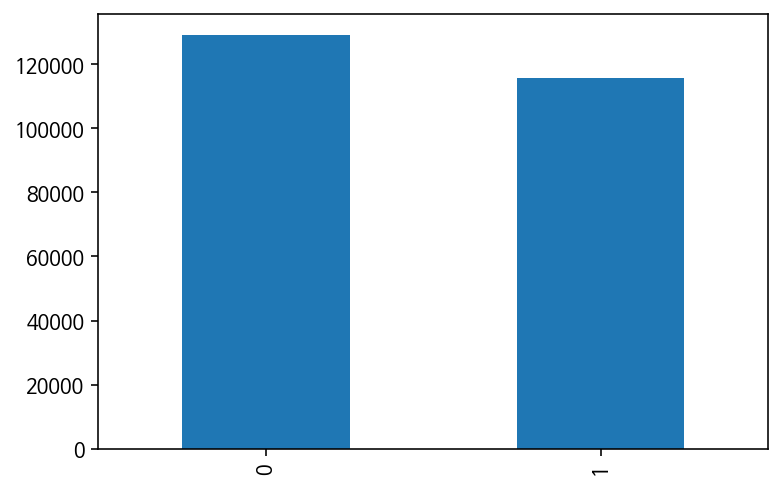

In [9]:
news['change'].value_counts().plot(kind = 'bar');

In [10]:
print(news.groupby('change').size().reset_index(name = 'count'))

   change   count
0       0  129183
1       1  115536


In [11]:
print(news.isnull().values.any()) # 널값 없음

False


### train, test split (2012 ~ 2019 : 2020 ~ 2021)

In [12]:
news['date'] = pd.to_datetime(news['date'])

In [13]:
split_date = pd.to_datetime('2020-01-01')

train = news[news['date'] < split_date]
test = news[news['date'] >= split_date]

In [14]:
len(train), len(test)

(198058, 46661)

### 데이터 정제 

#### 기사 헤드라인에 영문 또는 특수문자가 포함. 하지만 한국 주식 기사의 헤드라인으로 판단함으로 영문은 제외

In [15]:
train.head()

,name,headline,date,change
0,삼성전자,"[TV] 재계 총수들, 일자리 창출과 투자 확대 강조",2012-01-02,1
1,삼성전자,오너 3세들 '전진배치' 명과 암,2012-01-02,1
2,삼성전자,안철수연구소 개장 첫날 또 상한가,2012-01-02,1
3,삼성전자,[포토] 이건희 회장의 미소,2012-01-02,1
4,삼성전자,"재계 1위 삼성도 '정면돌파'…이건희 ""투자·채용 늘린다""",2012-01-02,1


In [16]:
# 많이 나오는 구두점과 특수기호에 대해 적절히 대체, 한글과 공백을 제외하고 모두 제거
train['headline'] = train['headline'].replace('..', ' ')
train['headline'] = train['headline'].replace('...', ' ') 
train['headline'] = train['headline'].replace("↓","하락")
train['headline'] = train['headline'].replace("↑","상승")
train['headline'] = train['headline'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train['headline'][:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

0      재계 총수들 일자리 창출과 투자 확대 강조
1              오너 세들 전진배치 명과 암
2           안철수연구소 개장 첫날 또 상한가
3                포토 이건희 회장의 미소
4    재계 위 삼성도 정면돌파이건희 투자채용 늘린다
Name: headline, dtype: object

- 기존의 공백은 유지되면서 온점과 같은 구두점 등은 모두 제거되었다.
- 기존에 한글이 없는 헤드라인이면 더 이상 아무값도 없을 것이다. 
- train headline에 공백만 있거나 빈 값을 가진 행이 있다면 Null로 변경하고, Null 값이 존재하는지 확인

In [17]:
import numpy as np

In [18]:
train['headline'] = train['headline'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train['headline'].replace('', np.nan, inplace=True)
print(train.isnull().sum())

name        0
headline    8
date        0
change      0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [19]:
train.loc[train.headline.isnull()][:5]

,name,headline,date,change
4223,삼성전자,NaN,2013-02-25,0
34167,SK하이닉스,NaN,2012-02-01,1
55306,LG화학,NaN,2012-11-15,0
92268,NAVER,NaN,2018-09-05,0
93371,NAVER,NaN,2019-06-25,1


- Null 샘플들은 레이블이 긍정일 수도 있고, 부정일 수도 있다. 아무런 의미도 없는 데이터므로 제거한다.

In [20]:
train = train.dropna(how = 'any')
print(len(train))

198050


#### test셋도 동일하게 진행

In [21]:
test['headline'] = test['headline'].replace('..', ' ')
test['headline'] = test['headline'].replace('...', ' ') 
test['headline'] = test['headline'].replace("↓","하락")
test['headline'] = test['headline'].replace("↑","상승")
test['headline'] = test['headline'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test['headline'] = test['headline'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test['headline'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test = test.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test))

전처리 후 테스트용 샘플의 개수 : 46156


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

- 앞서 train, test split을 16~20 : 21로 나누었었다.
- 정제를 하고보니 21년도 헤드라인이 16~20년도보다 어떤 특수문자나 영어로 많이 쓰였던 것 같다.

In [22]:
train.head()

,name,headline,date,change
0,삼성전자,재계 총수들 일자리 창출과 투자 확대 강조,2012-01-02,1
1,삼성전자,오너 세들 전진배치 명과 암,2012-01-02,1
2,삼성전자,안철수연구소 개장 첫날 또 상한가,2012-01-02,1
3,삼성전자,포토 이건희 회장의 미소,2012-01-02,1
4,삼성전자,재계 위 삼성도 정면돌파이건희 투자채용 늘린다,2012-01-02,1


### 토큰화

- 토큰화 과정에서 불용어를 제거할 예정.
- 불용어는 정의하기 나름, 한국어의 조사, 접속사 등의 보편적인 불용어를 사용하며,
- 추가적으로 풀고자 하는 문제의 데이터를 지속 검토하면서 계속해서 추가해야함.
- 따라서 headline의 텍스트를 유심히 살펴보면서 추가적인 불용어를 선정해줘야 함.

In [23]:
!pip install konlpy
from konlpy.tag import Okt
# from konlpy.tag import Kkma

     |████████████████████████████████| 19.4 MB 4.6 MB/s 
     |████████████████████████████████| 448 kB 56.9 MB/s 


In [24]:
# 한글자로 구성된 토큰도 삭제해준다
stopwords = ['의','가','이','은','들','는','걍','과','들','걍','과','으로','도','을','를','으로','자','에','와','한','하다','에서','에게'] 

In [25]:
okt = Okt()

In [26]:
from tqdm import tqdm

token_list = []
for sentence in tqdm(train['headline']):
    token = okt.morphs(sentence, stem=True) # 토큰
    token = [t for t in token if t not in stopwords] # 불용어 제거
    token_list.append(token)

100%|██████████| 198050/198050 [04:52<00:00, 676.58it/s]


In [27]:
token_list[:10]

[['재계', '총수', '일자리', '창', '추다', '투자', '확대', '강조'],
 ['오', '너', '세', '전진', '배치', '명과', '암'],
 ['안철수', '연구소', '개장', '첫날', '또', '상한'],
 ['포토', '이건희', '회장', '미소'],
 ['재계', '위', '삼성', '정면', '돌파', '이건희', '투자', '채용', '늘리다'],
 ['코스피', '임진년', '첫', '거래', '일', '외인', '기관', '공', '방속', '상승'],
 ['시가총액', '삼성', '그룹', '삼성', '주가', '상승', '시', '총', '증가'],
 ['클럽', '추천', '주', '삼성'],
 ['주요', '그룹', '신년사', '키', '워드', '투자', '확대', '동반성', '장', '통해', '위기', '돌파'],
 ['이재용', '회장', '동승', '시무', '식', '생략']]

In [28]:
tokens = pd.Series(token_list) # 인덱싱을 위해 시리즈로 변환
tokens[:10]

0                    [재계, 총수, 일자리, 창, 추다, 투자, 확대, 강조]
1                            [오, 너, 세, 전진, 배치, 명과, 암]
2                           [안철수, 연구소, 개장, 첫날, 또, 상한]
3                                   [포토, 이건희, 회장, 미소]
4               [재계, 위, 삼성, 정면, 돌파, 이건희, 투자, 채용, 늘리다]
5             [코스피, 임진년, 첫, 거래, 일, 외인, 기관, 공, 방속, 상승]
6                [시가총액, 삼성, 그룹, 삼성, 주가, 상승, 시, 총, 증가]
7                                     [클럽, 추천, 주, 삼성]
8    [주요, 그룹, 신년사, 키, 워드, 투자, 확대, 동반성, 장, 통해, 위기, 돌파]
9                            [이재용, 회장, 동승, 시무, 식, 생략]
dtype: object

In [29]:
freqeuncies = pd.Series(np.concatenate([w for w in token_list])).value_counts() # 빈도수 확인
freqeuncies

코스피     20127
삼성      18094
금융      13932
코스닥     11300
선       10119
        ...  
스페          1
친딸          1
왕새우         1
유로스타        1
서치          1
Length: 34880, dtype: int64

In [30]:
train['tokens'] = token_list

In [31]:
# train.head()

In [32]:
def get_freq_count(tokens):
  pos_token = list(train['tokens'][train['change'] == 1])
  neg_token = list(train['tokens'][train['change'] == 0])
  pos_freq = pd.Series(np.concatenate([w for w in pos_token])).value_counts()
  neg_freq = pd.Series(np.concatenate([w for w in neg_token])).value_counts()
  return pos_freq, neg_freq

def remove_doubled_words(pos_freq, neg_freq, tokens):
  # 긍정,부정에서 모두 사용되는 단어는 의미 없는 단어이므로 제거
  top_50_pos = pos_freq[:20]
  top_50_neg = neg_freq[:20]
  remove_words = [p for p in top_50_pos.index if p in top_50_neg.index]
  tokens_removed = remove_stop_words(tokens, remove_words)
  final_tokens = cleaning_tokens(tokens_removed)
  return final_tokens

def draw_top_hist(data,name,color): # 히스토그램을 그려줍니다.
  top_10 = data[:10]
  plt.figure(figsize=(12,7.5))
  plt.rc('font', family='NanumBarunGothic') 
  plt.suptitle("Bar Plot", fontsize=30)
  plt.title(name, fontsize=15)
  plt.bar(top_10.index,top_10.values, width=0.5, color= color, alpha=0.5)
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

In [33]:
pos_freq, neg_freq = get_freq_count(tokens)

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

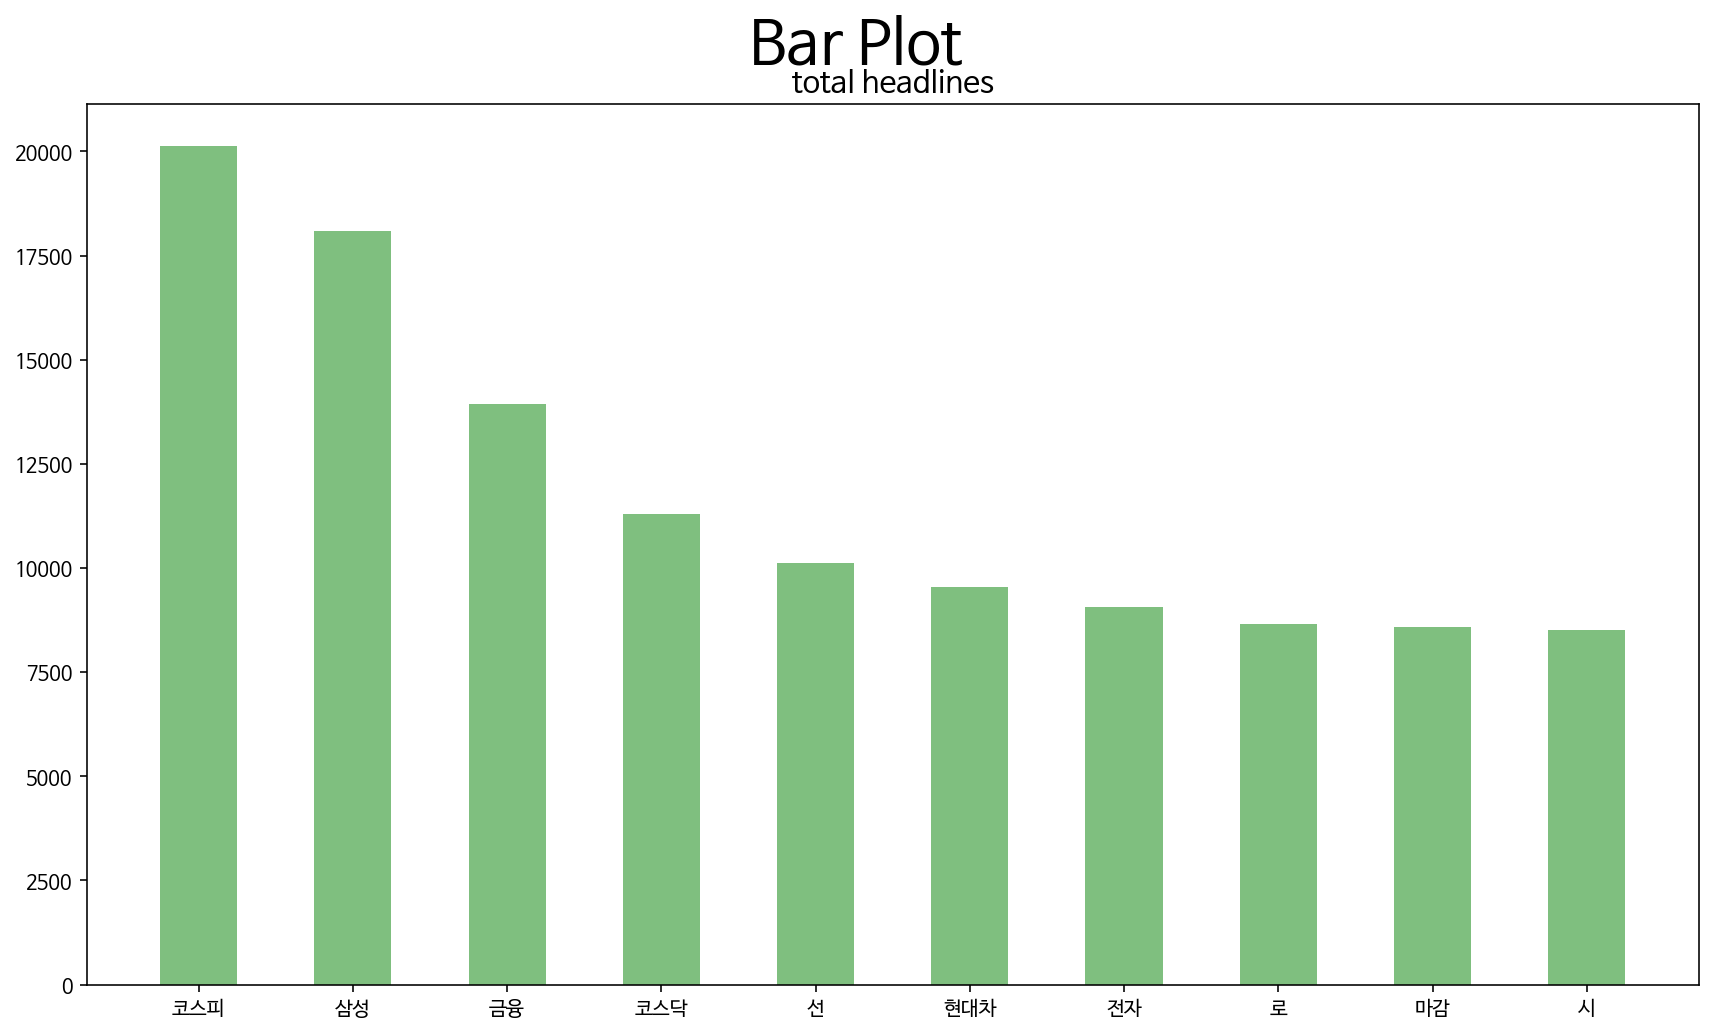

In [35]:
draw_top_hist(freqeuncies,'total headlines','g')

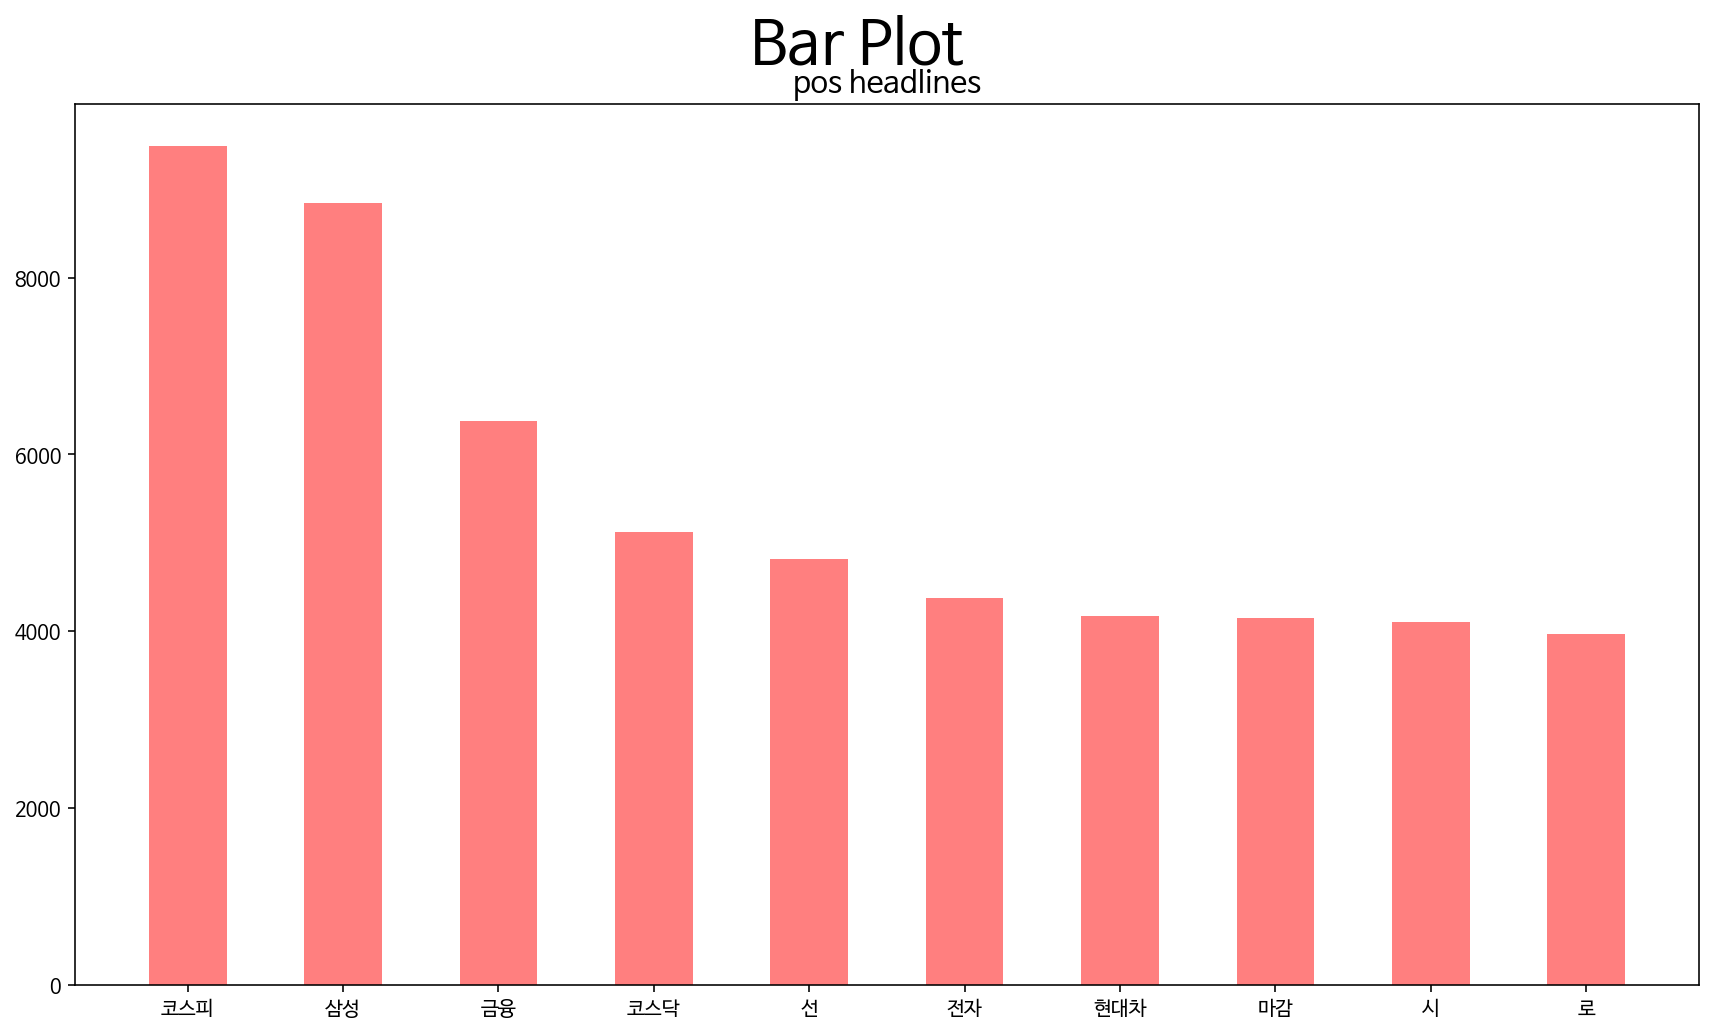

In [36]:
draw_top_hist(pos_freq,'pos headlines','r')

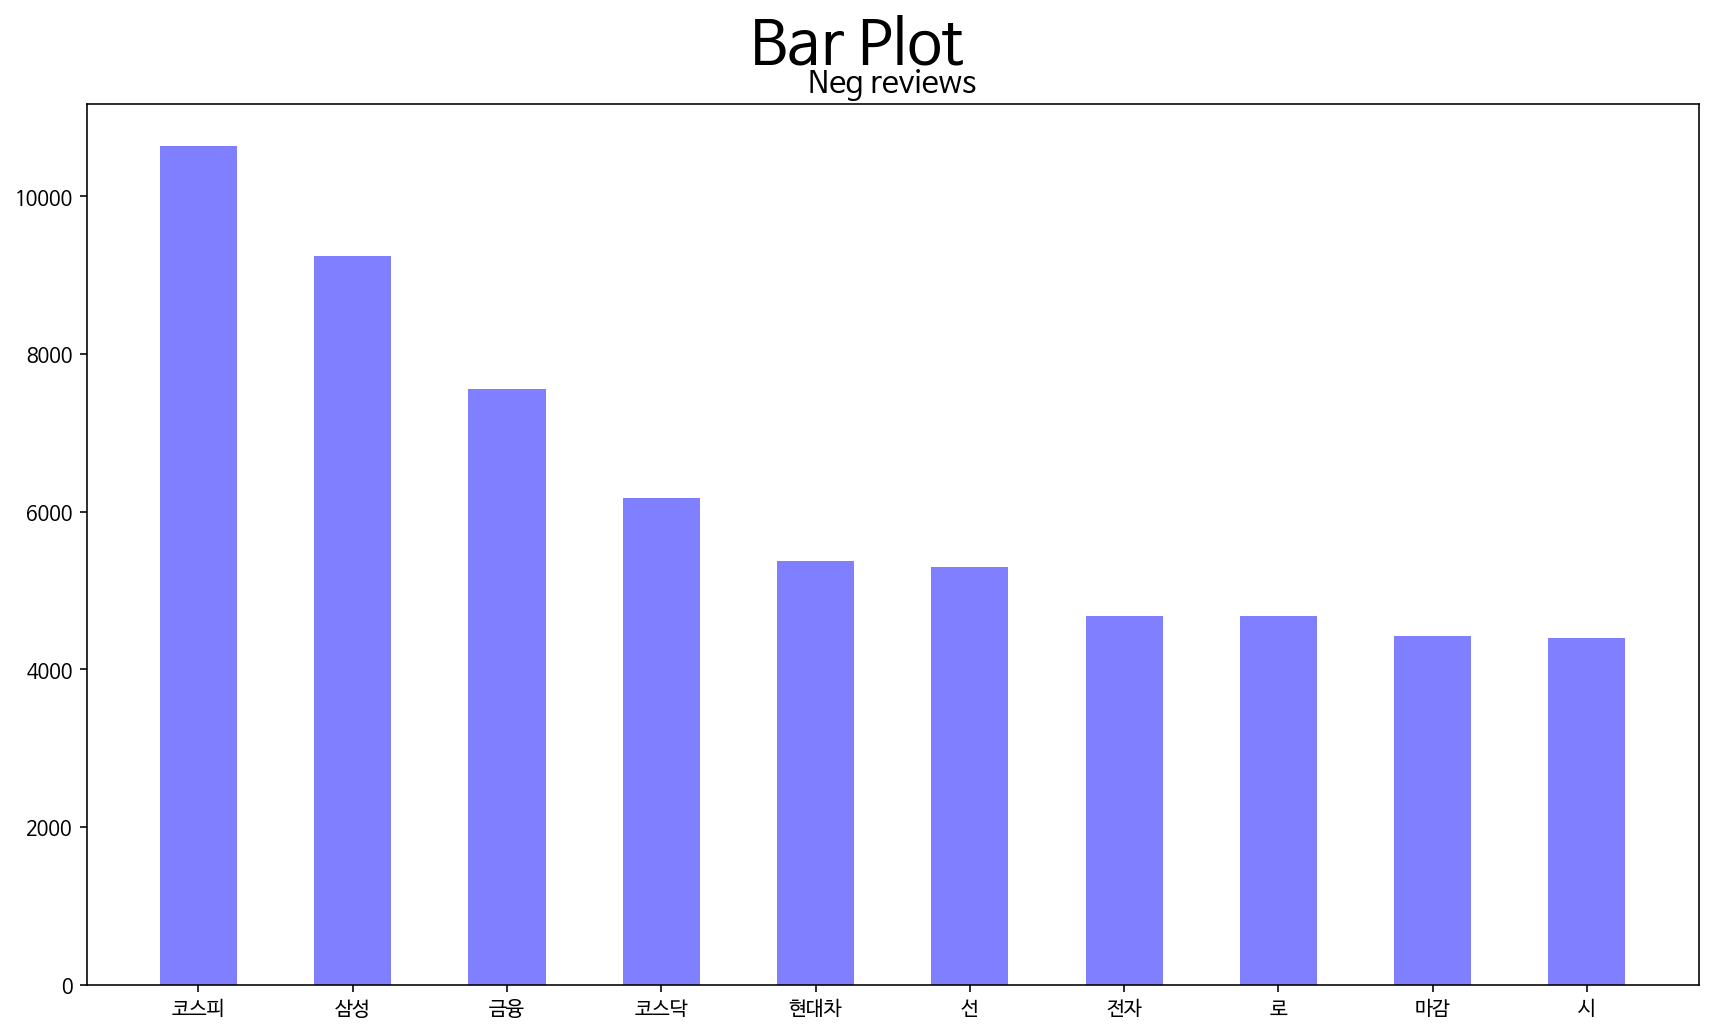

In [37]:
draw_top_hist(neg_freq,'Neg reviews','b')

In [38]:
top_50_pos = pos_freq[:10]
top_50_neg = neg_freq[:10]
common_words = [p for p in top_50_pos.index if p in top_50_neg.index]
common_words

['코스피', '삼성', '금융', '코스닥', '선', '전자', '현대차', '마감', '시', '로']

- 상위 10위에 공동으로 존재하는 토큰들을 전부 제거

In [39]:
total = freqeuncies.sum()
common_words_cnt = freqeuncies[common_words].sum()
print(f'total words count: {total} removed: {common_words_cnt} ratio: {common_words_cnt / total :.2f}')

total words count: 1651587 removed: 117899 ratio: 0.07


- 165만개의 사용횟수 중 7%정도의 빈도수가 겹치는 공통어 -> 불용어 처리해 제거

In [40]:
clean_token_list = []
for token in tokens:
  clean_token = list(filter(lambda x: x not in common_words,token))
  clean_token_list.append(clean_token)

In [41]:
clean_tokens = pd.Series(clean_token_list)
clean_tokens[:10]

0                    [재계, 총수, 일자리, 창, 추다, 투자, 확대, 강조]
1                            [오, 너, 세, 전진, 배치, 명과, 암]
2                           [안철수, 연구소, 개장, 첫날, 또, 상한]
3                                   [포토, 이건희, 회장, 미소]
4                   [재계, 위, 정면, 돌파, 이건희, 투자, 채용, 늘리다]
5                  [임진년, 첫, 거래, 일, 외인, 기관, 공, 방속, 상승]
6                           [시가총액, 그룹, 주가, 상승, 총, 증가]
7                                         [클럽, 추천, 주]
8    [주요, 그룹, 신년사, 키, 워드, 투자, 확대, 동반성, 장, 통해, 위기, 돌파]
9                            [이재용, 회장, 동승, 시무, 식, 생략]
dtype: object

- 다시 긍, 부정에서 많이 쓰이는 토큰 데이터를 확인

In [42]:
train['clean_tokens'] = clean_token_list

In [43]:
def get_freq_count2(clean_tokens):
  pos_token = list(train['clean_tokens'][train['change'] == 1])
  neg_token = list(train['clean_tokens'][train['change'] == 0])
  pos_freq = pd.Series(np.concatenate([w for w in pos_token])).value_counts()
  neg_freq = pd.Series(np.concatenate([w for w in neg_token])).value_counts()
  return pos_freq, neg_freq

In [44]:
pos_freq, neg_freq = get_freq_count2(clean_tokens)

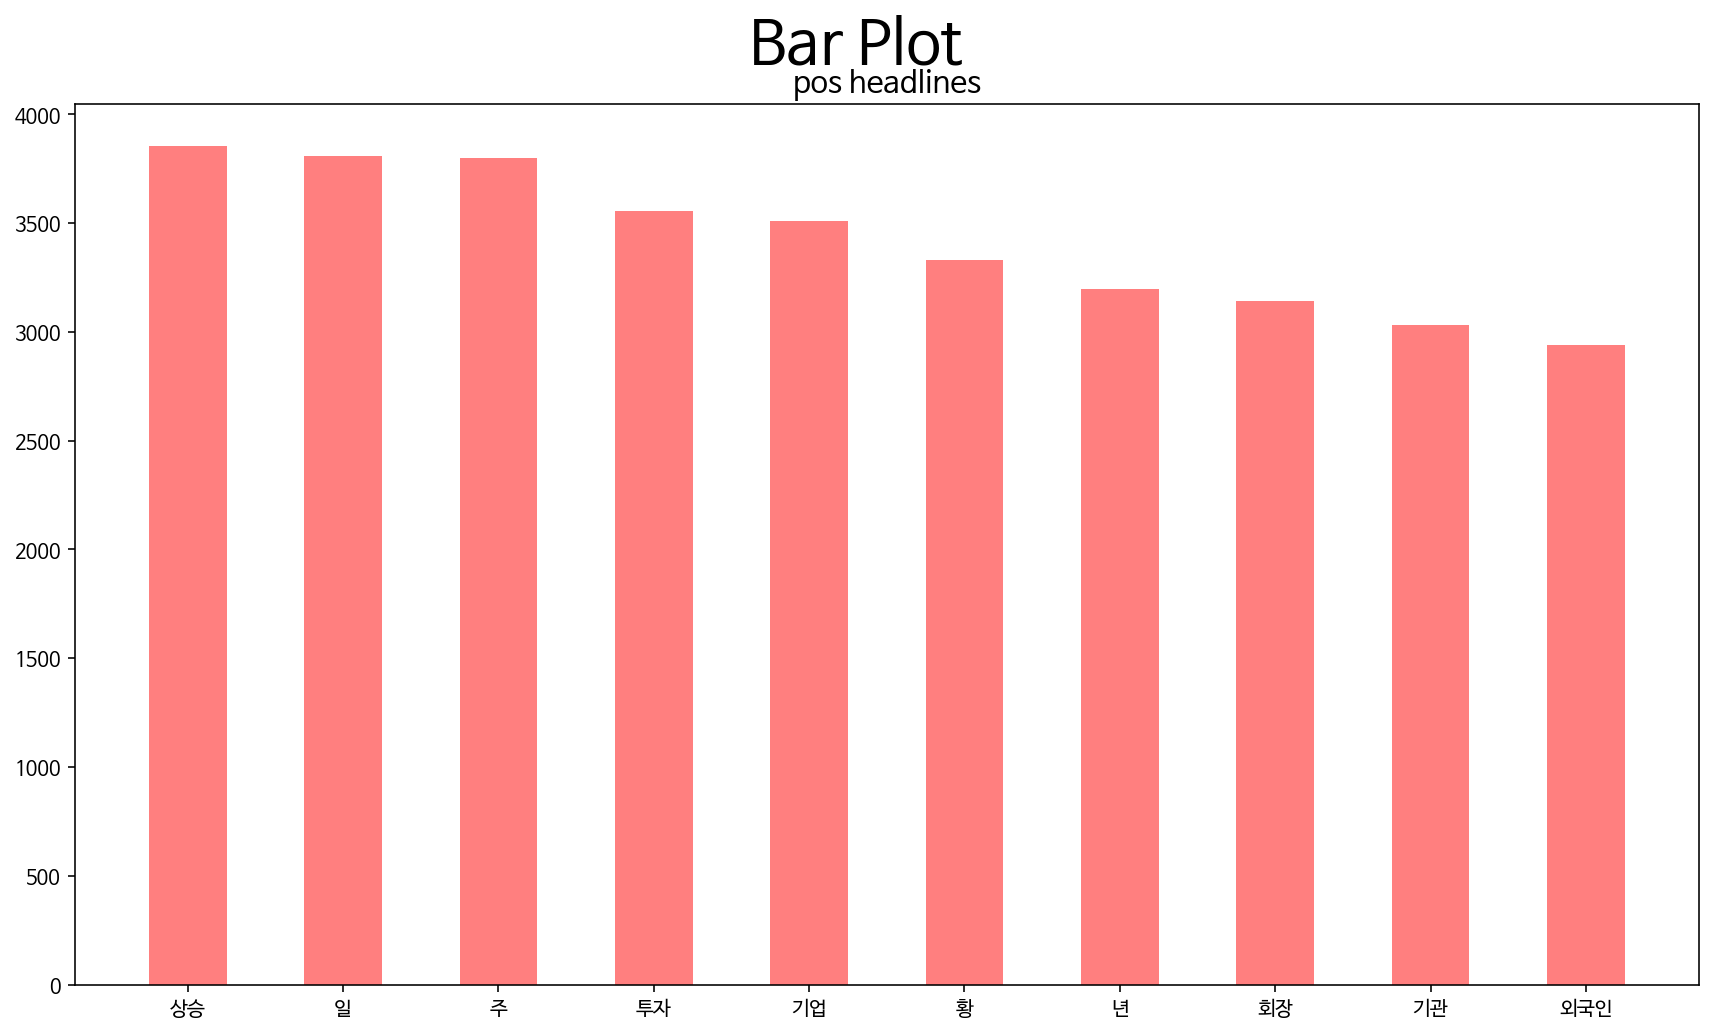

In [45]:
draw_top_hist(pos_freq,'pos headlines','r') # 다시 그린 긍정 headline 빈도수 히스토그램

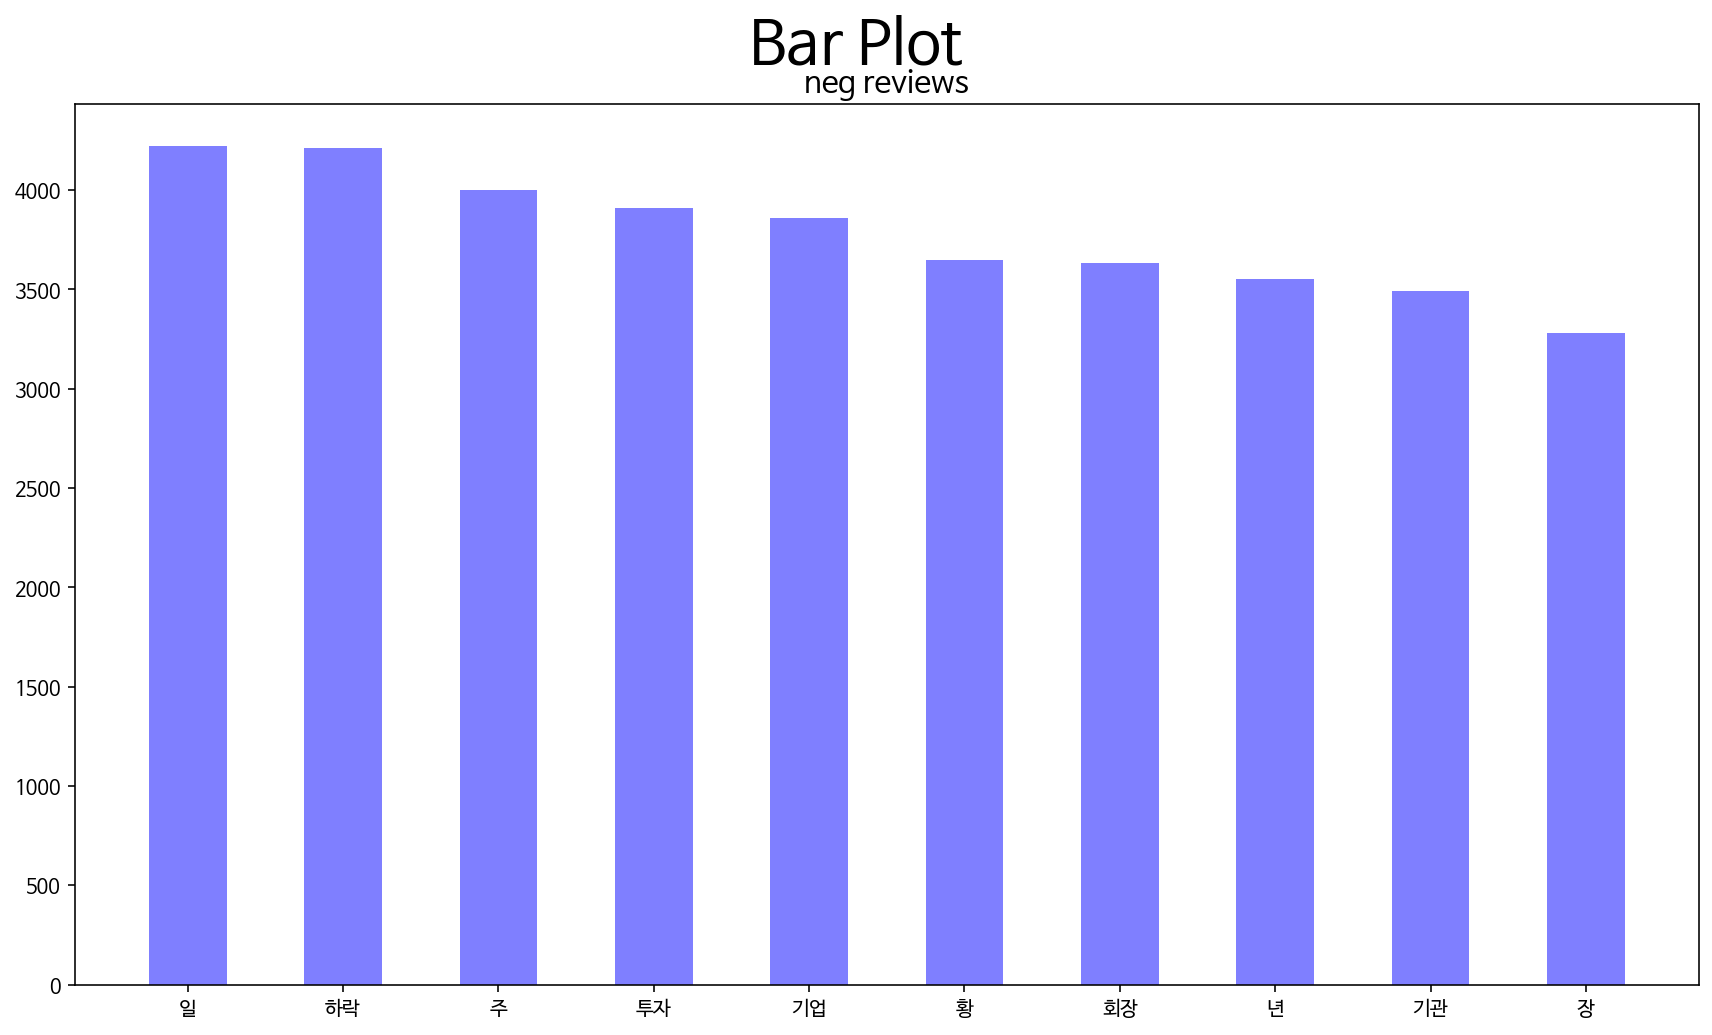

In [46]:
draw_top_hist(neg_freq,'neg reviews','b') # 다시 그린 부정 헤드라인 빈도수 히스토그램

In [47]:
top_50_pos = pos_freq[:10]
top_50_neg = neg_freq[:10]
common_words = [p for p in top_50_pos.index if p in top_50_neg.index]
common_words

['일', '주', '투자', '기업', '황', '년', '회장', '기관']

In [48]:
total = freqeuncies.sum()
common_words_cnt = freqeuncies[common_words].sum()
print(f'total words count: {total} removed: {common_words_cnt} ratio: {common_words_cnt / total :.2f}')

total words count: 1651587 removed: 57690 ratio: 0.03


In [49]:
clean_token_list2 = []
for token in clean_tokens:
    clean_token = list(filter(lambda x: x not in common_words, token))
    clean_token_list2.append(clean_token)

In [50]:
clean_tokens2 = pd.Series(clean_token_list2)
clean_tokens2[:10]

0                    [재계, 총수, 일자리, 창, 추다, 확대, 강조]
1                        [오, 너, 세, 전진, 배치, 명과, 암]
2                       [안철수, 연구소, 개장, 첫날, 또, 상한]
3                                   [포토, 이건희, 미소]
4                   [재계, 위, 정면, 돌파, 이건희, 채용, 늘리다]
5                     [임진년, 첫, 거래, 외인, 공, 방속, 상승]
6                       [시가총액, 그룹, 주가, 상승, 총, 증가]
7                                        [클럽, 추천]
8    [주요, 그룹, 신년사, 키, 워드, 확대, 동반성, 장, 통해, 위기, 돌파]
9                            [이재용, 동승, 시무, 식, 생략]
dtype: object

In [51]:
train['clean_tokens2'] = clean_token_list2

In [52]:
def get_freq_count3(clean_tokens2):
  pos_token = list(train['clean_tokens2'][train['change'] == 1])
  neg_token = list(train['clean_tokens2'][train['change'] == 0])
  pos_freq = pd.Series(np.concatenate([w for w in pos_token])).value_counts()
  neg_freq = pd.Series(np.concatenate([w for w in neg_token])).value_counts()
  return pos_freq, neg_freq

In [53]:
pos_freq, neg_freq = get_freq_count3(clean_tokens2)

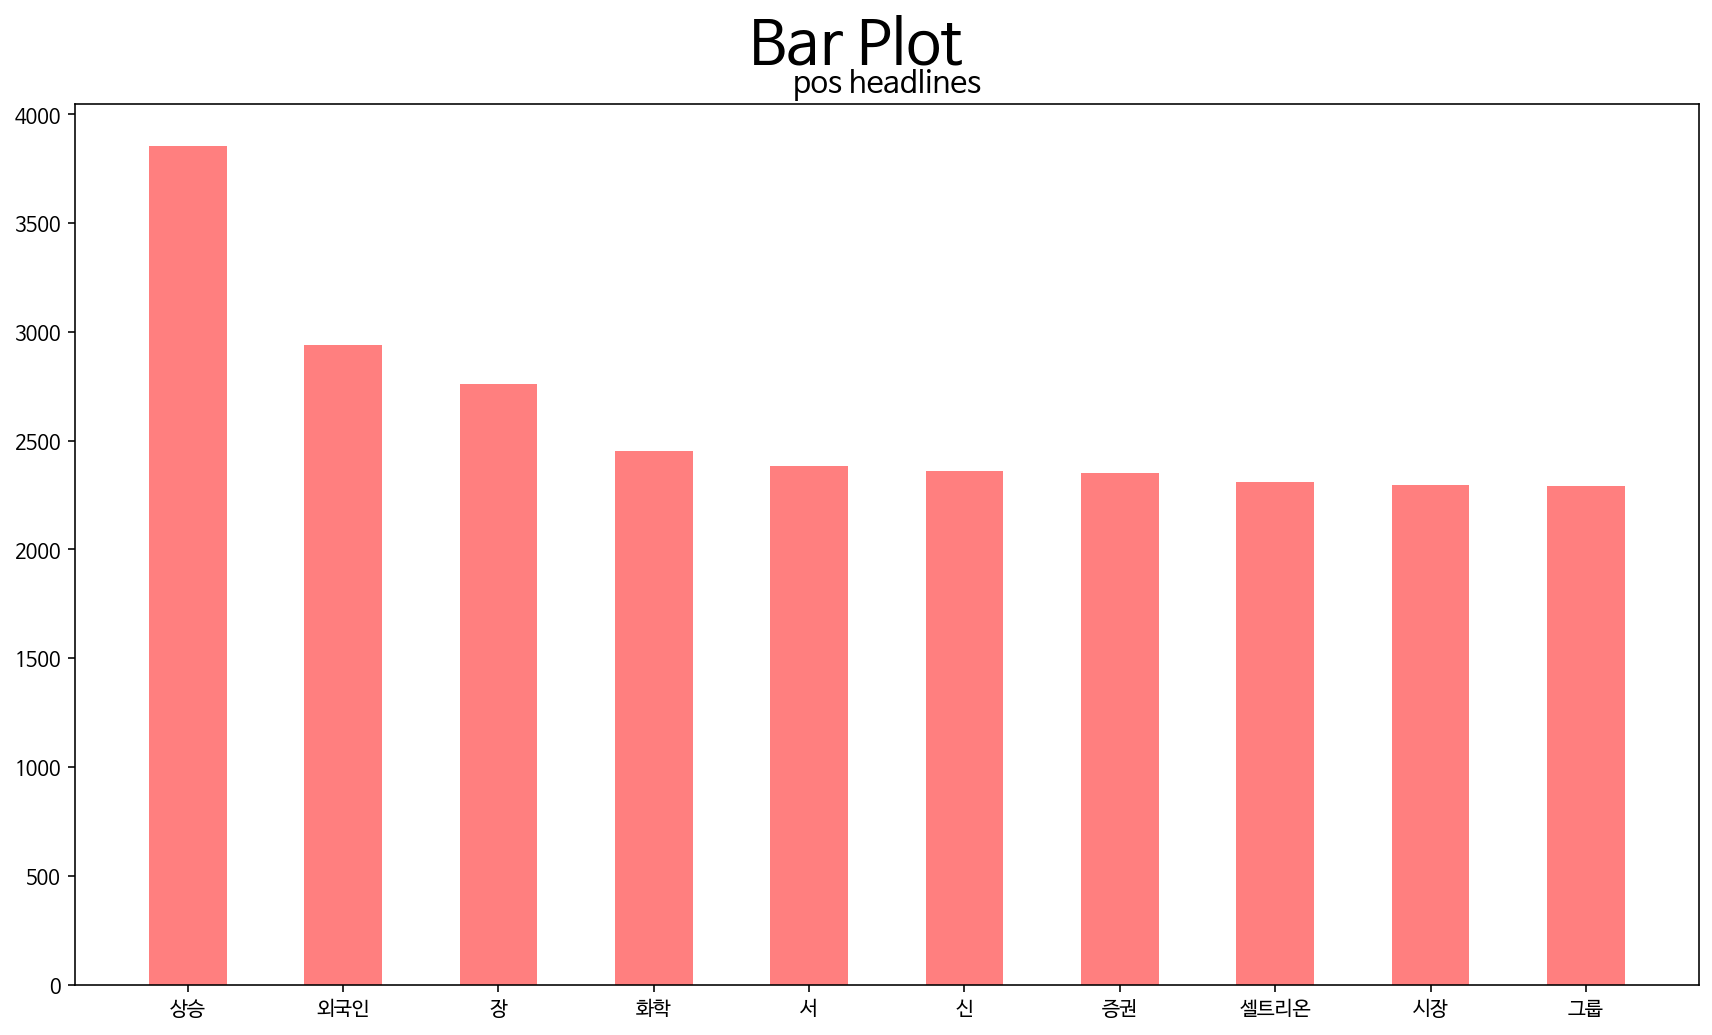

In [54]:
draw_top_hist(pos_freq,'pos headlines','r') # 다시 그린 긍정 headline 빈도수 히스토그램

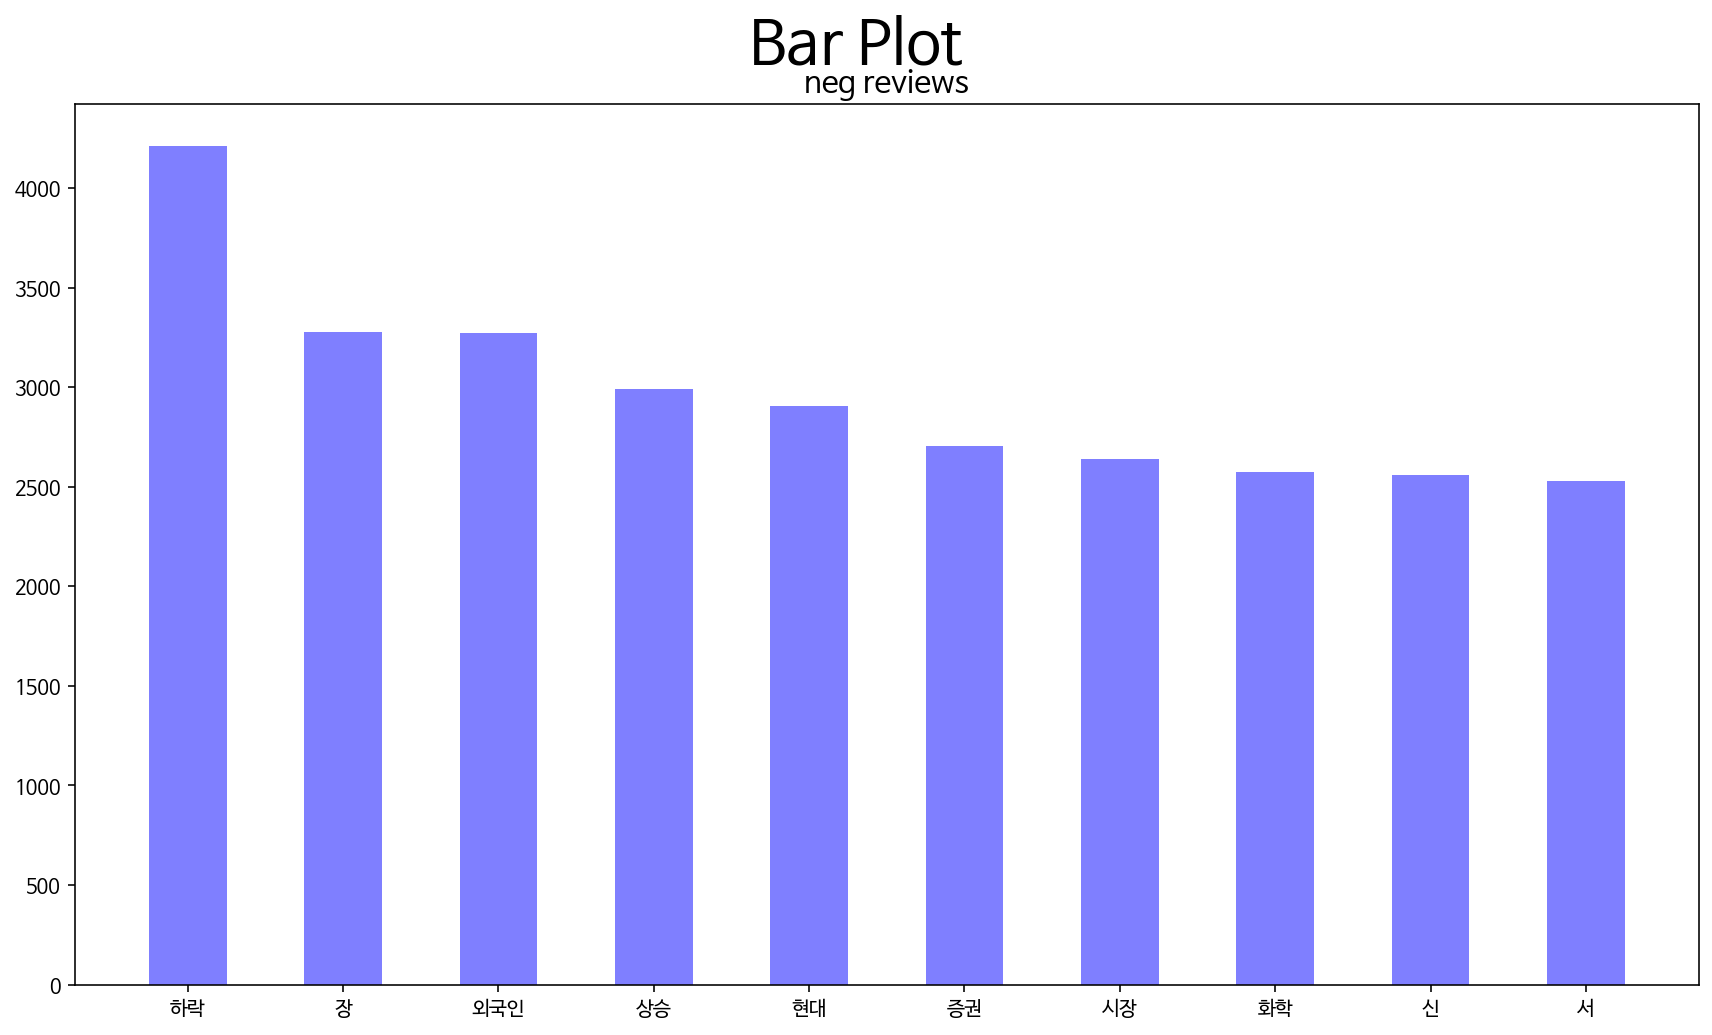

In [55]:
draw_top_hist(neg_freq,'neg reviews','b') # 다시 그린 부정 헤드라인 빈도수 히스토그램

In [56]:
print(f"Words kinds: {len(freqeuncies)}")

Words kinds: 34880


- 단어 사용 횟수는 165만, 34800개 정도의 단어를 사용


Text(0.5, 0.98, '21687 words explain 99.0% of total words dirtribution')

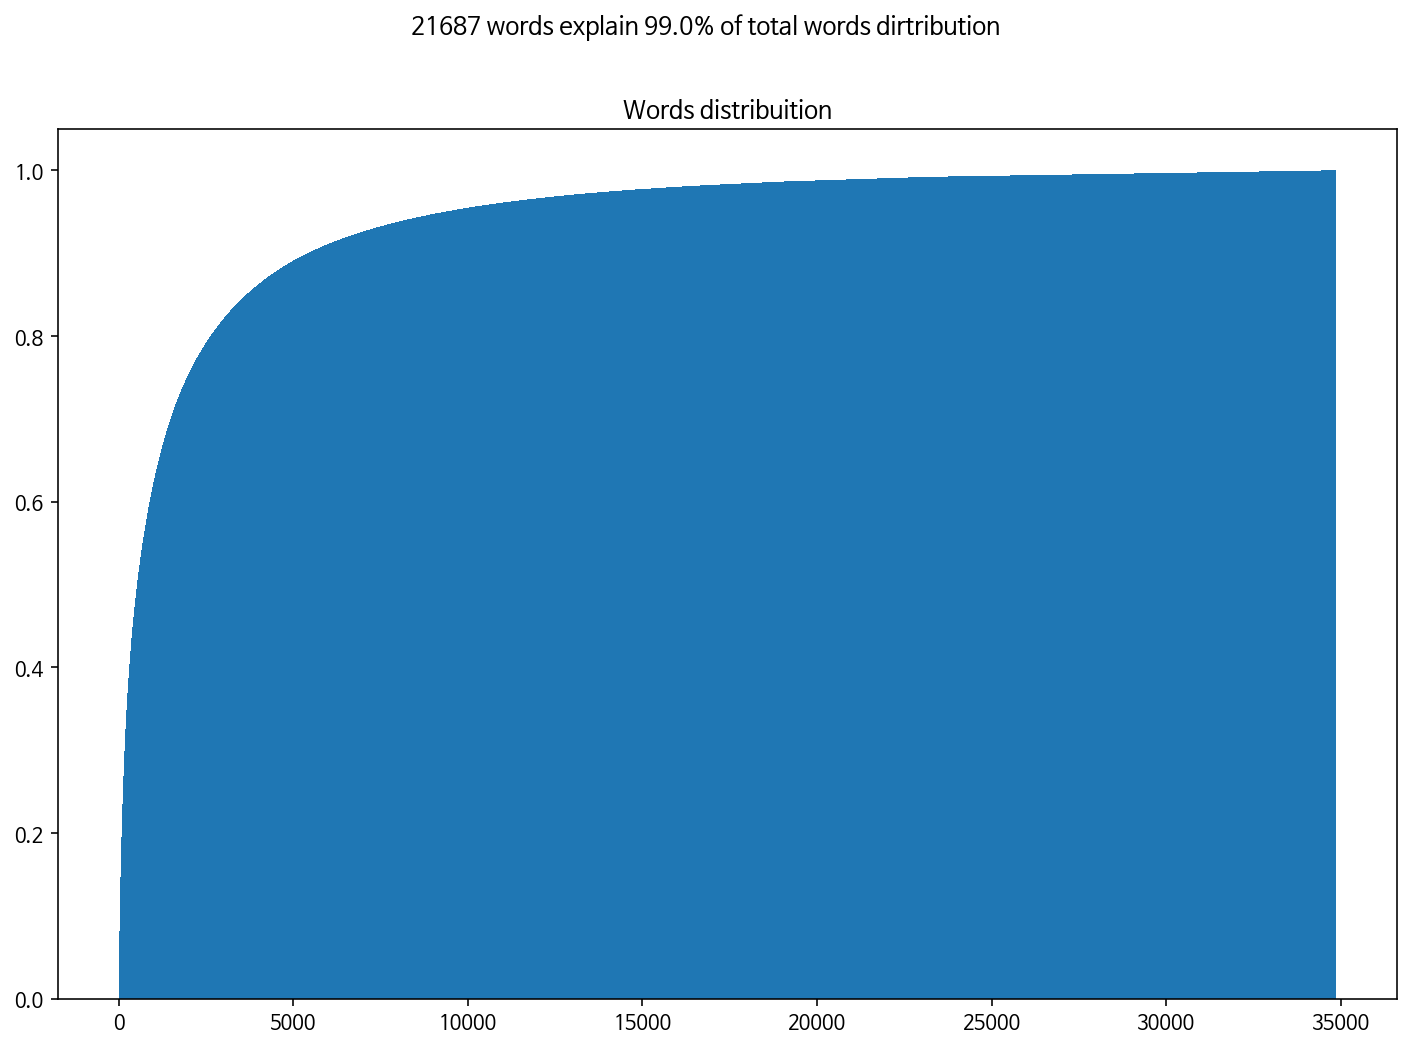

In [57]:
clean_frequencies = pd.Series(np.concatenate([w for w in clean_tokens2])).value_counts()
accumulate_words = np.add.accumulate(clean_frequencies) # 빈도수의 누적합을 구해줍니다.
ratio = 0.99
words_cnt = np.where(accumulate_words > sum(clean_frequencies) * 0.99)[0][0]
plt.figure(figsize=(12,8))
plt.bar(range(0,len(clean_frequencies)), accumulate_words / sum(clean_frequencies), width=1.0) # 전체 단어와 현재까지의 빈도수의 비율을 구해줍니다.
plt.title('Words distribuition')
plt.suptitle(f'{words_cnt} words explain {ratio * 100:.1f}% of total words dirtribution')

In [58]:
freqeuncies.describe()

count    34880.000000
mean        47.350545
std        324.072556
min          1.000000
25%          1.000000
50%          3.000000
75%         13.000000
max      20127.000000
dtype: float64

No handles with labels found to put in legend.


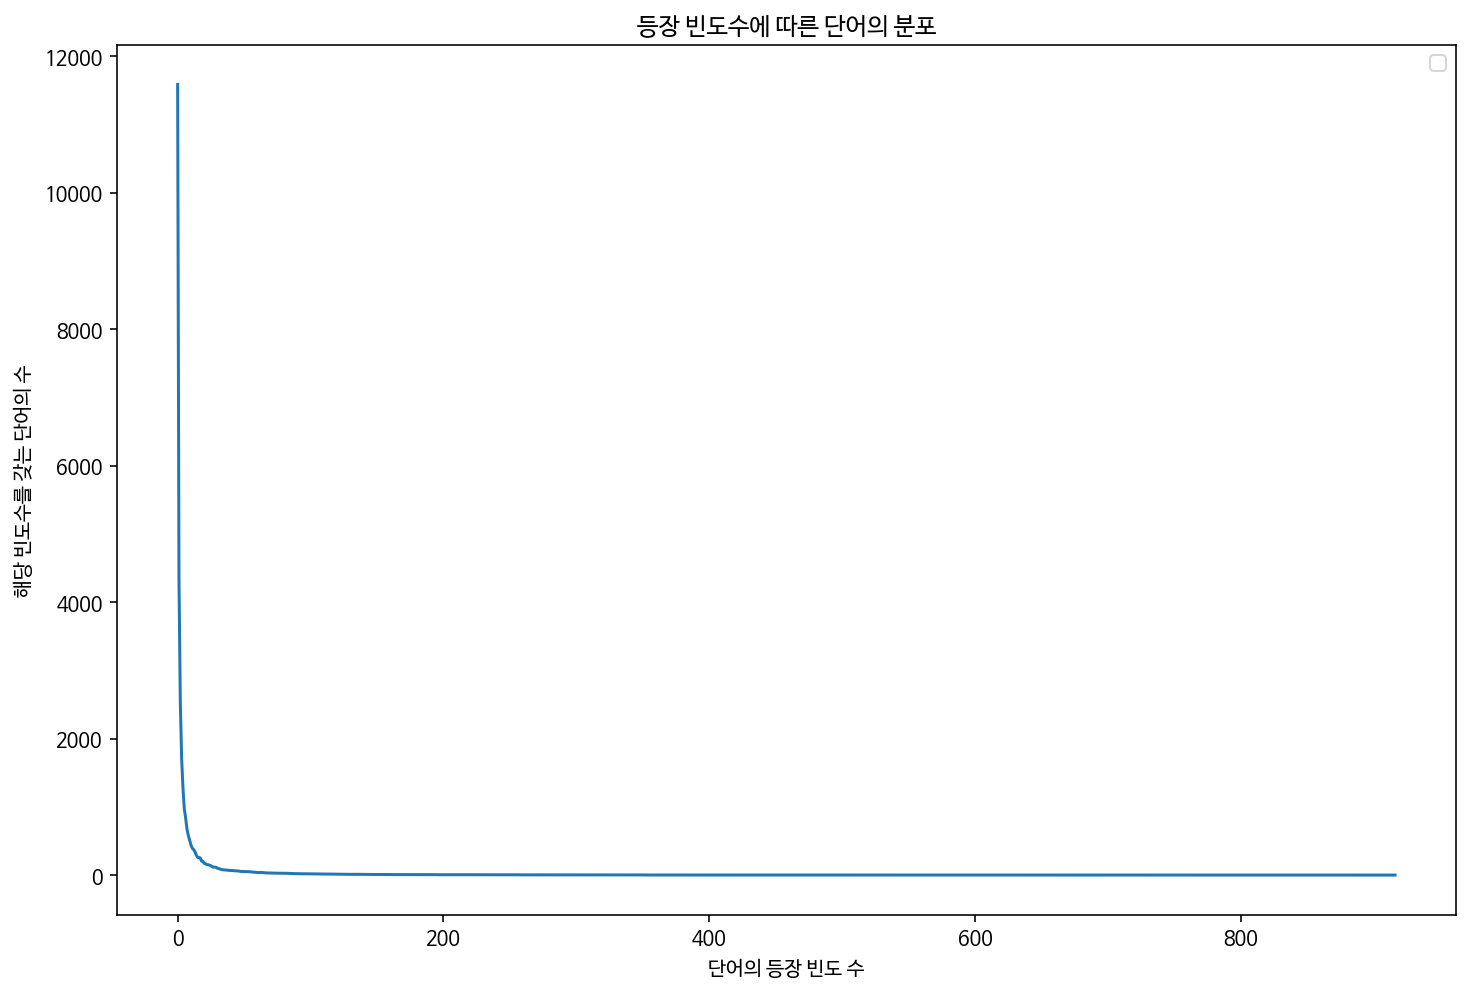

In [59]:
words_distribution = clean_frequencies.value_counts()
plt.figure(figsize=(12,8))
plt.plot(range(0,len(words_distribution)), words_distribution.values)
plt.ylabel("해당 빈도수를 갖는 단어의 수")
plt.xlabel("단어의 등장 빈도 수")
plt.title("등장 빈도수에 따른 단어의 분포")
plt.legend()